In [96]:
# Import needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from arch import arch_model

In [97]:
# --------------------
# PARAMETERS
# --------------------
start_date = '2010-01-01'
end_date = '2025-01-01'
ticker = '^GSPC'
split = 0.8
window = 30 

### **Data Preparation**

In [98]:
# Import daily returns (in %)
data = yf.download(tickers=ticker, start=start_date, end=end_date, auto_adjust=False)['Adj Close']

rets = 100 * np.log(data / data.shift(1))
rets = rets.dropna()

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

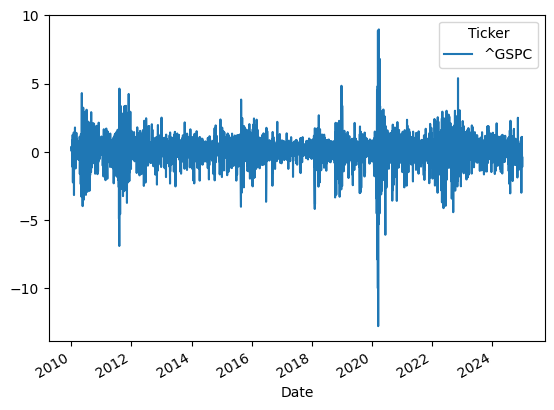

In [99]:
# VISUALISATION
rets.plot()

In [100]:
# Split training and test data
split_idx = int(rets.shape[0] * split)
train_data = rets[:split_idx]
test_data = rets[split_idx:]

### **Traditional ARCH(1) Model**

The ARCH(q) model is defined by the mean equation
$$
r_t = \mu + \epsilon_t
$$
and the shock decomposition
$$
\epsilon_t = \sigma_t z_t, \qquad z_t \sim i.i.d.\ (0,1).
$$

The conditional variance of an ARCH(q) model is
$$
\sigma_t^2 = \omega + \sum_{i=1}^{q} \alpha_i \epsilon_{t-i}^2,
$$
with the constraints
$$
\omega > 0, \qquad \alpha_i \ge 0, \qquad \sum_{i=1}^{q} \alpha_i < 1.
$$

For the ARCH(1) model, the conditional variance simplifies to
$$
\sigma_t^2 = \omega + \alpha_1 \epsilon_{t-1}^2,
$$
with constraints
$$
\omega > 0, \qquad \alpha_1 \ge 0, \qquad \alpha_1 < 1.
$$


In [101]:
# Defining and training ARCH(1) model on our training data
model_arch_1 = arch_model(train_data, vol='ARCH', p=1, mean='constant', dist='normal')
res_arch_1 = model_arch_1.fit()
print(res_arch_1.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: 66675641518276.28
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1724077169.480331
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4300.332187017626
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4180.104542939824
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4180.104478742644
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4180.104478742685
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4180.104478742644
            Iterations: 6
            Function evaluations: 32
            Gradient evaluations: 6
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                  ^GSPC   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -4180.10
Distribution:                  Normal   AIC: 

In [102]:
print(res_arch_1.params)

mu          0.086674
omega       0.680472
alpha[1]    0.410366
Name: params, dtype: float64


In [103]:
# Compute the in-sample predictions of the training data
predictions_training = pd.Series(res_arch_1.conditional_volatility, index=train_data.index)

In [104]:
# Prediction of the testing sample
train_data = train_data.squeeze()
test_data = test_data.squeeze()
predictions_testing = []
history = train_data.copy()

for idx in range(test_data.shape[0]):
    # Fit the model on history (train data + previous test points)
    model = arch_model(history, vol='ARCH', p=1, mean='constant', dist='normal')
    res = model.fit(disp='off')

    # Forecast 1-step ahead
    pred = res.forecast(horizon=1).variance.iloc[-1, 0]
    predictions_testing.append(np.sqrt(pred))

    # Add actual return to history
    new_point = pd.Series(
        data=[test_data.iloc[idx]],
        index=[test_data.index[idx]]
    )
    history = pd.concat([history, new_point])

predictions_testing = pd.Series(predictions_testing, index=test_data.index)

In [105]:
# Compute full predictions
full_predictions = pd.concat([predictions_training, predictions_testing])
full_predictions

Date
2010-01-05    1.032472
2010-01-06    0.837340
2010-01-07    0.825164
2010-01-08    0.848873
2010-01-11    0.834904
                ...   
2024-12-24    0.939146
2024-12-26    1.057460
2024-12-27    0.854554
2024-12-30    1.128535
2024-12-31    1.114042
Length: 3773, dtype: float64

In [108]:
# Compute rolling window of realized volatility
rets = rets.squeeze()
realized_var = (rets**2).rolling(window=window).mean()
realized_vol = realized_var ** 0.5

<Axes: xlabel='Date'>

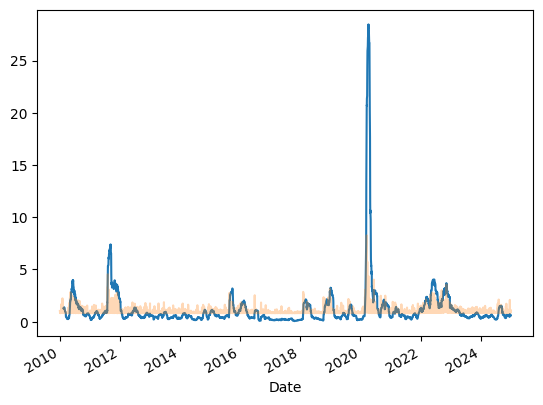

In [107]:
# Plot comparaison of the both and key metrics
realized_vol.plot()
full_predictions.plot(alpha=0.3)